In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchdiffeq import odeint
from torch import Tensor

import numpy as np
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_s_curve

from models.models import SimpleNN
from flow_matching.models import OTFM, SimplestFM
from visualization.types import Sampler2D
import sys

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.device(device)

device(type='cpu')

# 1 Experiments

As in Lipman et al. 2023, we use a MLP with 5-layers of 512 neurons for the 2D examples and the UNet architecture from Dhariwal & Nichol (2021) for the images. 

We generate results and compare the resutls for the models FM-OT and FM-Diffusion.

## 1.1 2D Experiments

### 1.1.1 make_moons

In [13]:
model=SimpleNN().to(device)
oftm = OTFM() 
sigma_min = 0
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.MSELoss()
n_epochs=10000

for _ in tqdm(range(n_epochs)):
    x_1 = torch.tensor(make_moons(256)[0], dtype=torch.float32, device=device)
    x_0 = torch.randn_like(x_1,dtype=torch.float32, device=device)
       
    t = torch.rand(len(x_1), 1, dtype=torch.float32, device=device)

    dx_t = oftm.compute_dx_t(x_0, x_1, sigma_min)
    x_t = oftm.compute_x_t(x_0, x_1, sigma_min, t)
    
    ut, sigma_t = (1-t)*x_0+t*x_1, torch.tensor(0.001)
    
    # Expand sigma_t to match dimensions of ut
    sigma_t = sigma_t.expand_as(ut)
    
    # Now sample from N(ut, sigma_t)
    new_x_0 = torch.normal(mean=ut, std=sigma_t)
    optimizer.zero_grad()
    
    v_pred = model(new_x_0, t)
    loss_fn(v_pred ,dx_t).backward()
    
    optimizer.step()    

del x_1, x_0, t, dx_t, x_t


100%|██████████| 10000/10000 [00:37<00:00, 265.15it/s]


In [36]:
model=SimpleNN().to(device)
oftm = OTFM() 
sigma_min = 0
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.MSELoss()
n_epochs=20000

for _ in tqdm(range(n_epochs)):
    x_1 = torch.tensor(make_moons(256)[0], dtype=torch.float32, device=device)
    x_0 = torch.randn_like(x_1,dtype=torch.float32, device=device)
       
    t = torch.rand(len(x_1), 1, dtype=torch.float32, device=device)

    dx_t = x_1 - x_0    
    ut, sigma_t = t*x_1 + (1-t)*x_0, torch.tensor(sigma_min)
    sigma_t = sigma_t.expand_as(ut)
    sigma_t_squared = torch.pow(sigma_t,2)
    
    new_x_0 = torch.normal(mean=ut, std=sigma_t)
    optimizer.zero_grad()
    
    v_pred = model(new_x_0, t)
    loss_fn(v_pred ,dx_t).backward()
    
    optimizer.step()    

del x_1, x_0, t, dx_t


100%|██████████| 20000/20000 [01:29<00:00, 224.69it/s]


In [37]:
x_0 = torch.randn(256, 2, dtype=torch.float32, device=device)
sampler = Sampler2D(model, time_steps=6, x_0=x_0)

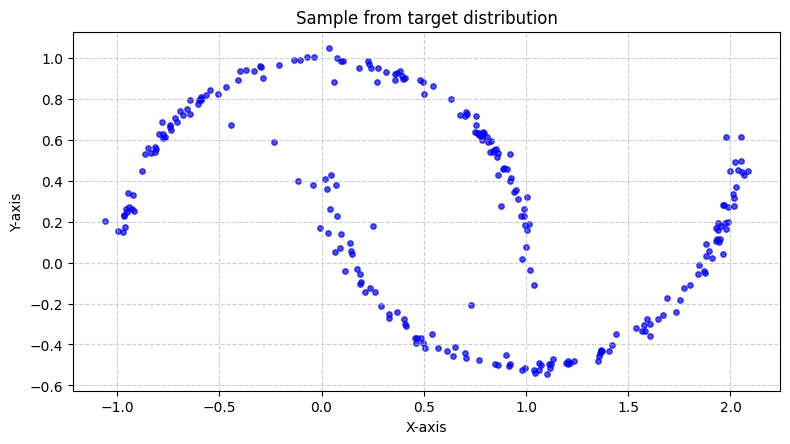

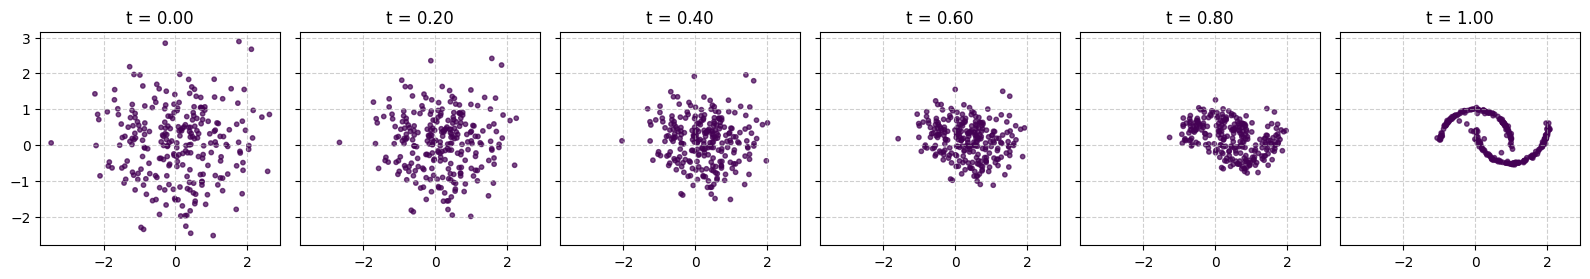

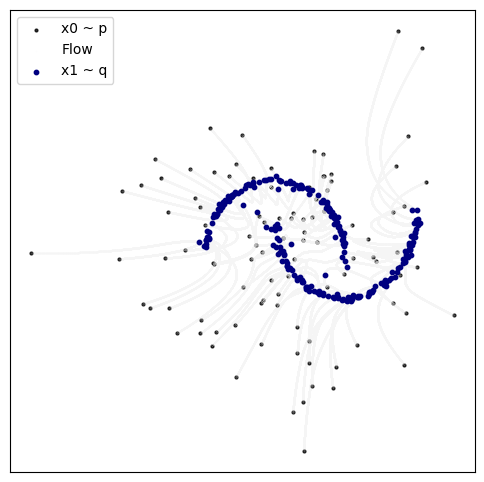

In [38]:
sampler.plot_sample()
sampler.plot_flow()
sampler.plot_trajectories(n=100)

### 1.1.1 From Gaussian to Gaussian and Optimal Transport

In [ ]:
model = SimpleNN()
oftm = OTFM() 
sigma_min = 0
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.MSELoss()
n_epochs=30000

for _ in tqdm(range(n_epochs)):
    
    n = 256
    u = [10, 10]  # Mean
    std = 3  # Standard deviation

    x_1 = Tensor(np.random.normal(loc=u, scale=std, size=(n, 2)))
    x_0 = torch.randn_like(x_1)
       
    t = torch.rand(len(x_1), 1)

    dx_t = oftm.compute_dx_t(x_0, x_1, sigma_min)
    x_t = oftm.compute_x_t(x_0, x_1, sigma_min, t)
    
    optimizer.zero_grad()
    
    v_pred = model(x_t, t)
    loss_fn(v_pred ,dx_t).backward()
    
    optimizer.step()     

In [40]:
model = SimpleNN()
oftm = OTFM() 
sigma_min = 0
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.MSELoss()
n_epochs=30000

for _ in tqdm(range(n_epochs)):
    
    n = 256
    u = [10, 10]  # Mean
    std = 3  # Standard deviation

    x_1 = Tensor(np.random.normal(loc=u, scale=std, size=(n, 2)))
    x_0 = torch.randn_like(x_1)
       
    t = torch.rand(len(x_1), 1)

    dx_t = oftm.compute_dx_t(x_0, x_1, sigma_min)
    x_t = oftm.compute_x_t(x_0, x_1, sigma_min, t)
    
    optimizer.zero_grad()
    
    v_pred = model(x_t, t)
    loss_fn(v_pred ,dx_t).backward()
    
    optimizer.step()     

100%|██████████| 30000/30000 [01:47<00:00, 279.36it/s]


In [7]:
x_0 = torch.randn_like(x_1)
sampler = Sampler2D(model, x_0, 6)

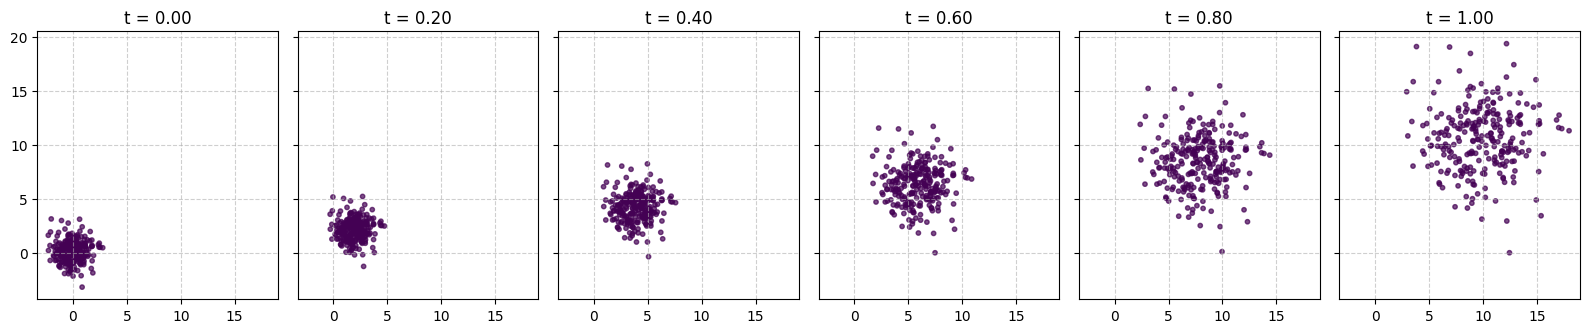

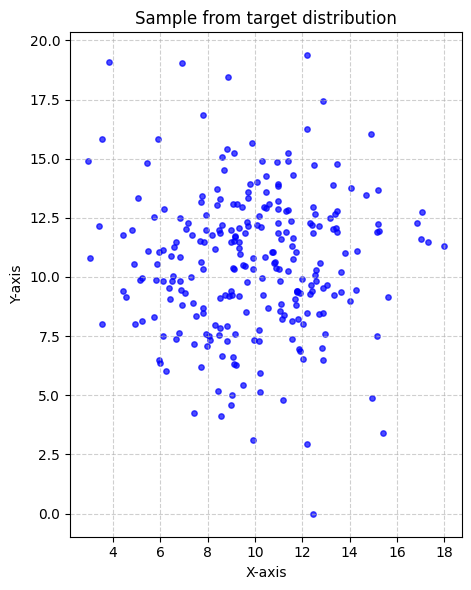

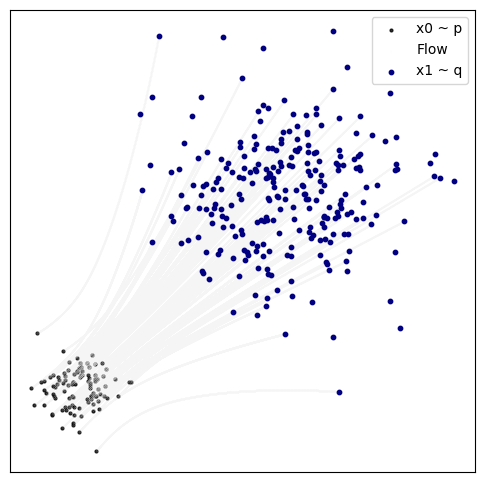

In [8]:
sampler.plot_flow()
sampler.plot_sample()
sampler.plot_trajectories(n=100)

### 1.1.2 Simplest Flow Matching

In [254]:
# Optimal Transport conditional VFs

net_model=SimpleNN()
simplestFM = SimplestFM() 
sigma_min = 0
optimizer=torch.optim.Adam(net_model.parameters())
loss_fn=nn.MSELoss()
n_epochs=15000

for _ in tqdm(range(n_epochs)):
    x_1 =Tensor(make_moons(256)[0])
    x_0 =torch.randn_like(x_1)
    
    t =torch.rand(len(x_1), 1)

    dx_t = simplestFM.compute_dx_t(x_0, x_1)
    x_t = simplestFM.compute_x_t(x_0, x_1, t)
    
    optimizer.zero_grad()
    
    v_pred = net_model(x_t, t)
    loss_fn(v_pred ,dx_t).backward()
    
    optimizer.step() 

100%|██████████| 15000/15000 [02:11<00:00, 114.30it/s]


### Checkers

In [ ]:
from data.datasets import generate_checkboard_batch

In [78]:
model=SimpleNN()
otfm = OTFM() 
sigma_min = 0
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.MSELoss()
n_epochs=20000

for _ in tqdm(range(n_epochs)):
    x_1 =generate_checkboard_batch(batch_size=4096)
    x_0 =torch.randn_like(x_1)
    
    t =torch.rand(len(x_1), 1)

    dx_t = otfm.compute_dx_t(x_0, x_1, sigma_min)
    x_t = otfm.compute_x_t(x_0, x_1, sigma_min,t)
    
    optimizer.zero_grad()
    
    v_pred = model(x_t, t)
    loss_fn(v_pred ,dx_t).backward()
    
    optimizer.step() 

100%|██████████| 20000/20000 [02:46<00:00, 120.11it/s]


In [79]:
x_0 = torch.randn_like(x_1)
sampler = Sampler2D(model, x_0, 6)

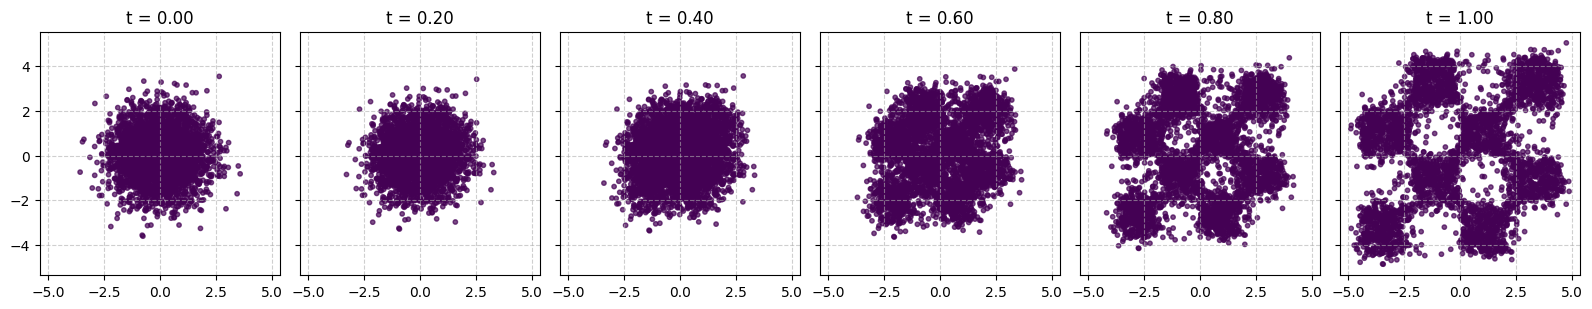

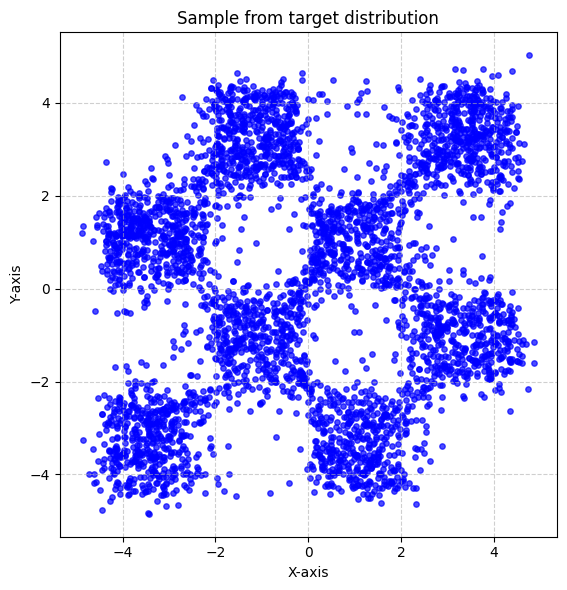

In [80]:
sampler.plot_flow()
sampler.plot_sample()

## 1.2  MNIST

In [9]:
from models.unet.model_configs import MODEL_CONFIGS
from models.unet.unet import UNetModel

In [10]:
batch_size = 32

dataset = datasets.MNIST(
    root="./data_mnist",
    train=True, 
    download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

# Filter the dataset to include only classes 1 and 7
#subset_indices = [i for i, (img, label) in enumerate(dataset) if label in [1, 7]]
#subset_indices = np.random.choice(subset_indices, size=1000, replace=False).tolist()
#dataset_subset = torch.utils.data.Subset(dataset, subset_indices)

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True, 
)

# architecture
architecture = "mnist"
model = UNetModel(**MODEL_CONFIGS[architecture])

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:01<00:00, 7.30MB/s]


Extracting ./data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data_mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 390kB/s]


Extracting ./data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.37MB/s]


Extracting ./data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.77MB/s]

Extracting ./data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_mnist/MNIST/raw



In [11]:
from typing import Iterable
from torchmetrics.aggregation import MeanMetric

# adapted from https://github.com/facebookresearch/flow_matching/blob/main/flow_matching/path/scheduler/scheduler.py
def train_one_epoch(
    model: torch.nn.Module,
    data_loader: Iterable,
    optimizer: torch.optim.Optimizer,
    lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
    device: torch.device,
    epoch: int,
    fm: object,
    sigma_min: float = 0.001,
) -> dict:
    """
    Train model for one epoch.
    
    Args:
        model: PyTorch model to train
        data_loader: Data loader providing (samples, labels) pairs
        optimizer: PyTorch optimizer
        lr_scheduler: Learning rate scheduler
        device: Device to train on
        epoch: Current epoch number
        otfm: Object containing OT flow map computations
        sigma_min: Minimum sigma value for noise
    
    Returns:
        dict: Dictionary containing epoch loss
    """
    model.train()
    batch_loss = MeanMetric().to(device, non_blocking=True)
    epoch_loss = MeanMetric().to(device, non_blocking=True)

    for data_iter_step, (samples, labels) in enumerate(data_loader):
        optimizer.zero_grad()
        
        samples = samples.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        conditioning = {"label":labels}
        x_0 = torch.randn_like(samples).to(device)  
        
        # Scaling samples to [-1, 1] from [0, 1]
        x_1 = samples * 2.0 - 1.0

        # Generate random timesteps
        t = torch.rand(len(samples), 1, 1, 1).to(device)
        
        # Compute OT flow map values
        dx_t = otfm.compute_dx_t(x_0, x_1, sigma_min)
        x_t = otfm.compute_x_t(x_0, x_1, sigma_min, t)
        
        # Forward pass and loss computation
        pred = model(x_t, t, extra=conditioning)
        loss = torch.pow(pred - dx_t, 2).mean()
        
        # Update metrics
        batch_loss.update(loss.detach())
        epoch_loss.update(loss.detach())

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Logging
        if data_iter_step % 2000 == 0:
            lr = optimizer.param_groups[0]["lr"]
            print(
                f"Epoch {epoch} [{data_iter_step}/{len(data_loader)}]: "
                f"loss = {batch_loss.compute():.4f}, lr = {lr:.6f}"
            )

    lr_scheduler.step()
    return {"loss": float(epoch_loss.compute().detach().cpu())}

In [12]:
# Rest of the training loop
lr = 0.001
sigma_min = 0
n_epochs = 5

loss_fn = nn.MSELoss()
otfm = OTFM()

optimizer = torch.optim.AdamW(model.parameters(), lr)
lr_schedule = torch.optim.lr_scheduler.ConstantLR(
    optimizer, total_iters=n_epochs, factor=1.0
)

for epoch in range(n_epochs):
    
    train_stats = train_one_epoch(model, dataloader, optimizer=optimizer, lr_scheduler=lr_schedule, device=device, epoch=epoch, fm=otfm, sigma_min=sigma_min)
    
    epoch_loss = train_stats["loss"]
    print(f"Epoch {epoch} completed. Average loss: {epoch_loss:.4f}")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [1]:
def visualize_mnist_flow(model, n_samples=10, n_steps=8, device='cuda'):
    """
    Visualize the flow from noise to MNIST-like images.
    
    Args:
        model: The trained UNet model
        n_samples: Number of images to generate
        n_steps: Number of intermediate steps to show
        device: Device to run the model on
    """

    model.eval()
    
    # Generate initial random noise
    x = torch.randn(n_samples, 1, 28, 28).to(device)
    
    # Create subplots
    fig, axes = plt.subplots(n_samples, n_steps + 1, figsize=(2*(n_steps + 1), 2*n_samples))
    time_steps = torch.linspace(0, 1.0, n_steps + 1)
    
    # Plot initial noise samples
    for j in range(n_samples):
        axes[j, 0].imshow(x[j, 0].cpu().detach(), cmap='gray')
        axes[j, 0].axis('off')
    axes[0, 0].set_title(f't={time_steps[0]:.2f}')
    
    # Perform steps and plot samples at each step
    with torch.no_grad():
        for i in range(n_steps):
            t_start = torch.tensor([time_steps[i]], device=device).view(1, 1, 1, 1).expand(n_samples, -1, -1, -1)
            t_end = torch.tensor([time_steps[i + 1]], device=device).view(1, 1, 1, 1).expand(n_samples, -1, -1, -1)
            
            x = model.step(x, t_start, t_end)
            
            # Plot each sample
            for j in range(n_samples):
                axes[j, i + 1].imshow(x[j, 0].cpu().detach(), cmap='gray')
                axes[j, i + 1].axis('off')
            axes[0, i + 1].set_title(f't={time_steps[i + 1]:.2f}')
    
    plt.tight_layout()
    plt.show()

In [2]:
visualize_mnist_flow(model, n_samples=5, n_steps=8, device=device)

NameError: name 'model' is not defined

In [12]:
dataloader.dataset.data[0].shape

torch.Size([28, 28])

In [15]:
from models.models import ModelWrapper

In [23]:
class ModelWrapperMNIST(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):

        t_reshaped = torch.reshape(t.expand(x.shape[0]),(-1,1))       

        return self.model(x, t_reshaped, {})


In [28]:
samples, labels = next(iter(dataloader))

In [31]:
samples.shape

torch.Size([32, 1, 28, 28])

In [32]:
x1 = samples
x0 = torch.rand_like(x1)
t = torch.linspace(0, 1, 10)
wrapped_model =  ModelWrapperMNIST(model)
solution = odeint(wrapped_model, x0, t, method="dopri5")

RuntimeError: expand(torch.FloatTensor{[32, 64, 1, 1, 1]}, size=[-1, -1, 7, 7]): the number of sizes provided (4) must be greater or equal to the number of dimensions in the tensor (5)

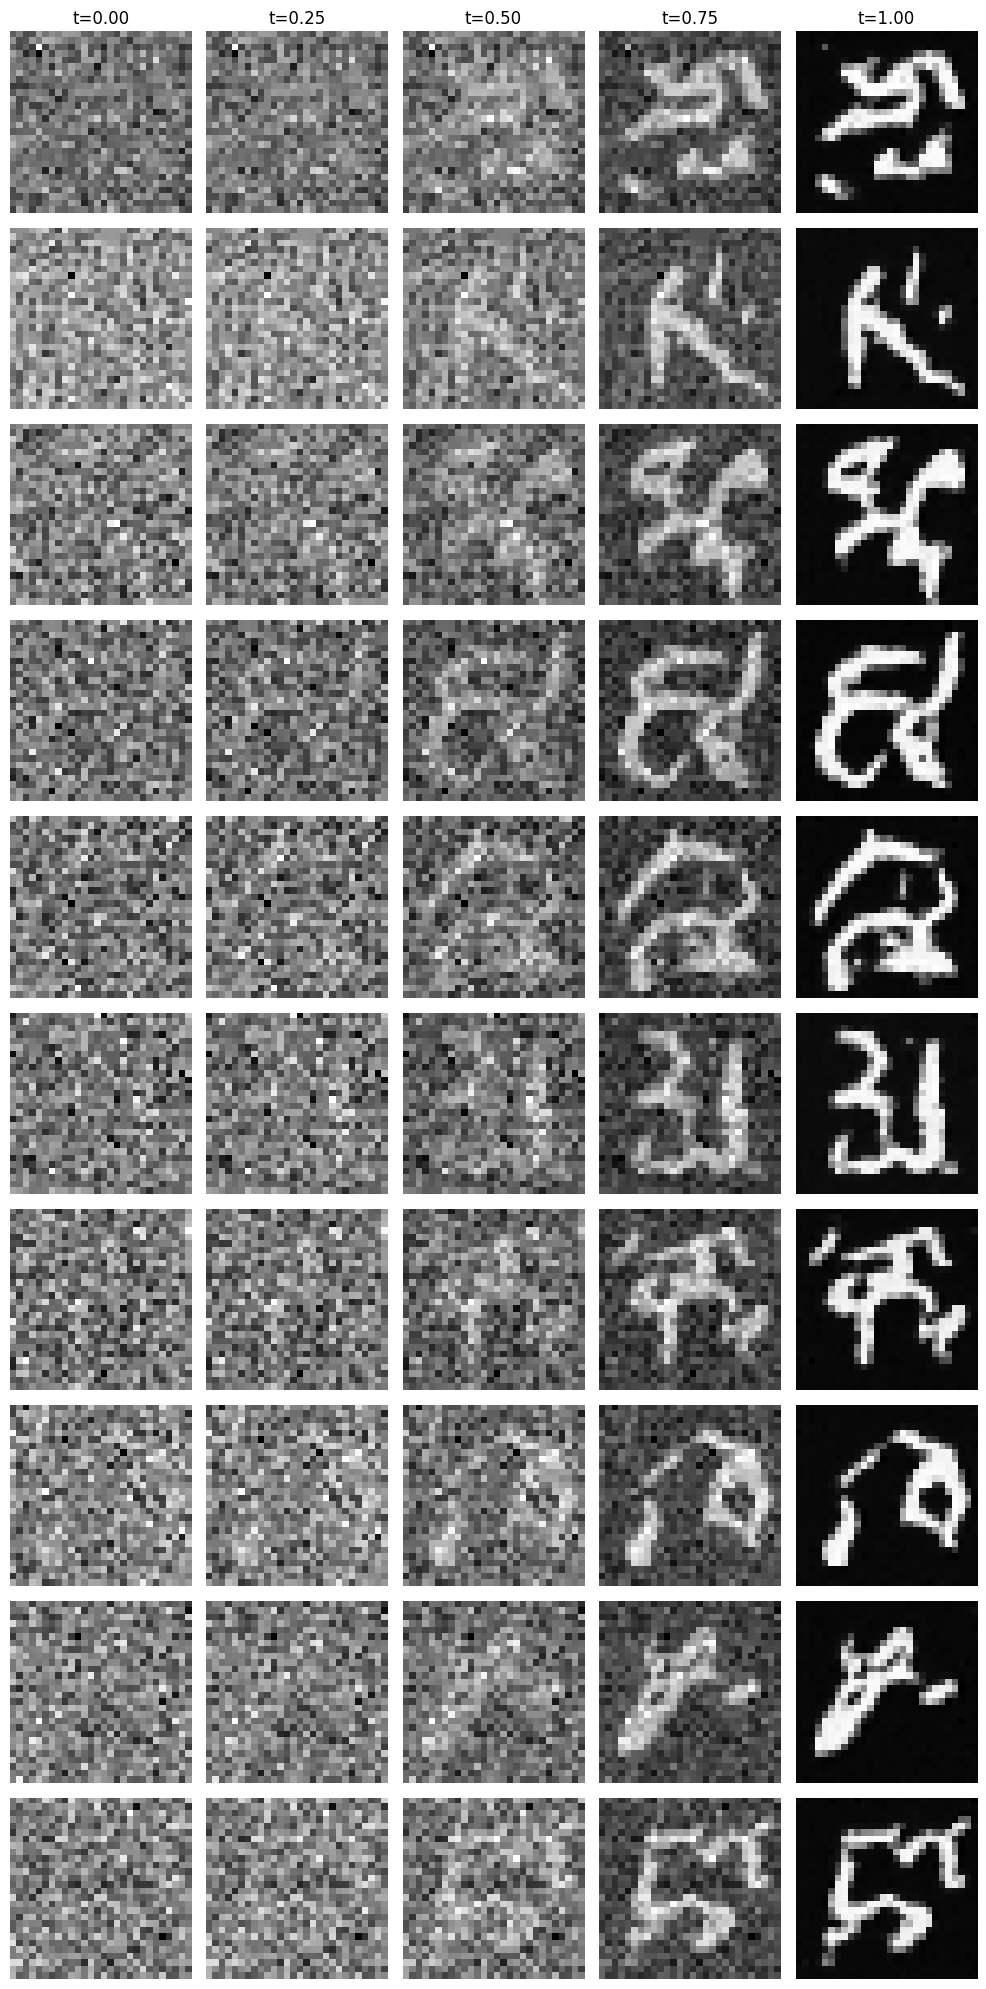

In [21]:
sampler.visualize_mnist_flow(net_model, n_samples=10, n_steps=4, device=device)

## 1.4 CIFAR10

We start by implemeting the flow matching and applying it to the CIFAR10 (Krizhevsky et al., 2009) dataset. As in Lipman et al., 2023, we evaluate likelihood and samples from the model using dopri5 (Dormand & Prince, 1980).

In [13]:
batch_size = 128
num_channel = 128
num_workers = 4
lr = 2e-4

In [14]:
dataset = datasets.CIFAR10(
    root="./data_cifar10",
    train=True, 
    download=True, 
    transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
)

subset_indices = list(range(256))  # Use the first 256 samples
dataset_subset = torch.utils.data.Subset(dataset, subset_indices)

dataloader = torch.utils.data.DataLoader(
    dataset_subset, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True, 
)

100%|██████████| 170M/170M [00:05<00:00, 30.7MB/s] 


Extracting ./data_cifar10/cifar-10-python.tar.gz to ./data_cifar10


In [15]:
net_model = UNetModelWrapper(
    dim=(3, 32, 32),
    num_res_blocks=2,
    num_channels=num_channel,
    channel_mult=[1, 2, 2, 2],
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="16",
    dropout=0.1,
).to(
    device
)

NameError: name 'UNetModelWrapper' is not defined

In [36]:
# training
optmizer = torch.optim.Adam(net_model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
otfm = OTFM()
sigma_min = 0.001
n_epochs = 10

for epoch in range(n_epochs):
    net_model.train()
    running_loss = 0.0
    
    print("epoch: ", epoch)
    
    for batch, _ in dataloader:
        
        batch = batch.to(device)
        
        x_0 = torch.randn_like(batch).to(device)

        x_1 = batch

        t = torch.rand(len(batch), 3, 32, 32).to(device)
        
        x_t = otfm.compute_x_t(x_0, x_1, sigma_min)
        dx_t = otfm.compute_dx_t(x_0, x_1, sigma_min, t)
        
        optmizer.zero_grad()
        
        loss = loss_fn(net_model(t, x_t), dx_t)
        
        loss.backward()        
        optmizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(dataloader)}")

epoch:  0
Epoch 1/10, Loss: 0.17949417233467102
epoch:  1
Epoch 2/10, Loss: 0.17611891776323318
epoch:  2
Epoch 3/10, Loss: 0.1601923257112503
epoch:  3
Epoch 4/10, Loss: 0.16158664971590042
epoch:  4
Epoch 5/10, Loss: 0.15941228717565536
epoch:  5
Epoch 6/10, Loss: 0.15786418318748474
epoch:  6
Epoch 7/10, Loss: 0.1569773033261299
epoch:  7
Epoch 8/10, Loss: 0.15630418807268143
epoch:  8
Epoch 9/10, Loss: 0.15595542639493942
epoch:  9
Epoch 10/10, Loss: 0.1557096466422081


In [37]:

class FlowMatchingSampler:
    def __init__(self, net_model, device='cuda'):
        self.net_model = net_model
        self.device = device
        
    def vector_field(self, t, x):
        """Vector field for ODE solver"""
        # Reshape t to match the expected input shape of the model
        t_shaped = t.reshape(1, 1, 1, 1).expand(x.shape[0], 3, 32, 32).to(self.device)
        return self.net_model(t_shaped, x)
    
    def generate_samples(self, num_samples, rtol=1e-5, atol=1e-5):
        """
        Generate samples using the trained flow matching model
        
        Args:
            num_samples: Number of samples to generate
            rtol: Relative tolerance for ODE solver
            atol: Absolute tolerance for ODE solver
        """
        # Initial noise
        x_0 = torch.randn(num_samples, 3, 32, 32).to(self.device)
        
        # Time points for integration
        t = torch.linspace(0, 1, 2).to(self.device)
        
        # Solve ODE
        self.net_model.eval()
        with torch.no_grad():
            samples = odeint(
                self.vector_field,
                x_0,
                t,
                method='dopri5',
                rtol=rtol,
                atol=atol
            )
        
        # Return final samples (at t=1)
        return samples[-1]

def save_samples(samples, filename):
    """Helper function to save generated samples"""
    # Ensure samples are in correct range [0, 1]
    samples = torch.clamp(samples, 0, 1)
    # Save as grid of images
    torchvision.utils.save_image(
        samples,
        filename,
        nrow=int(np.sqrt(len(samples))),
        normalize=True
    )



In [40]:
# Initialize sampler
sampler = FlowMatchingSampler(net_model, device=device)

# Generate samples
num_samples = 4
samples = sampler.generate_samples(num_samples)

# Save samples
save_samples(samples, "flow_matching_samples.png")


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[4, 3, 32, 32] to have 1 channels, but got 3 channels instead